### ETAPA 1: Preparação dos Dados para Recomendação

In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from dotenv import load_dotenv, find_dotenv
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

#### Carregando dotenv

In [2]:
load_dotenv(find_dotenv())
CSV = os.getenv("CSV_PATH")

In [3]:
caminho_dados = f'{CSV}vendas.csv'

df_vendas = pd.read_csv(caminho_dados, sep=',', encoding='utf-8')


In [4]:
# Garante que a coluna de data de compra está no formato correto
df_vendas['date_purchase'] = pd.to_datetime(df_vendas['date_purchase'])

# Cria a coluna 'hora_da_compra' a partir de 'time_purchase'
df_vendas['hora_da_compra'] = pd.to_datetime(df_vendas['time_purchase'], format='%H:%M:%S').dt.hour

# Cria a coluna 'dia_da_semana' a partir de 'date_purchase'
dias_semana_map = {
    'Monday': '2-Segunda', 'Tuesday': '3-Terça', 'Wednesday': '4-Quarta',
    'Thursday': '5-Quinta', 'Friday': '6-Sexta', 'Saturday': '7-Sábado', 'Sunday': '1-Domingo'
}
df_vendas['dia_da_semana'] = df_vendas['date_purchase'].dt.day_name().map(dias_semana_map)

print("Colunas 'hora_da_compra' e 'dia_da_semana' criadas com sucesso.")
df_vendas[['date_purchase', 'time_purchase', 'hora_da_compra', 'dia_da_semana']].head()

Colunas 'hora_da_compra' e 'dia_da_semana' criadas com sucesso.


,date_purchase,time_purchase,hora_da_compra,dia_da_semana
0,2021-02-23,20:08:25,20,3-Terça
1,2021-02-11,22:25:15,22,5-Quinta
2,2021-02-19,19:11:40,19,6-Sexta
3,2021-07-02,11:41:19,11,6-Sexta
4,2022-07-14,10:16:52,10,5-Quinta


In [5]:
# 1. Criar a feature 'rota'
# Concatenamos origem e destino para criar um identificador único para o trecho
df_vendas['rota'] = df_vendas['place_origin_departure'] + ' -> ' + df_vendas['place_destination_departure']

# 2. Ordenar as transações por cliente e data
# Isso é crucial para sabermos qual foi a "próxima" compra
df_vendas['datetime'] = pd.to_datetime(df_vendas['date_purchase'].astype(str) + ' ' + df_vendas['time_purchase'])
df_vendas = df_vendas.sort_values(by=['fk_contact', 'datetime'])


# 3. CRIAR A VARIÁVEL-ALVO (y)
# Para cada compra, a nossa "resposta certa" é a rota da compra seguinte
# Usamos shift(-1) agrupado por cliente para "puxar" a próxima rota para a linha atual
df_vendas['proxima_rota'] = df_vendas.groupby('fk_contact')['rota'].shift(-1)

# 4. Criar o DataFrame de treino
# Removemos a última transação de cada cliente, pois não temos a "próxima rota" para ela
df_recomendacao = df_vendas.dropna(subset=['proxima_rota']).copy()


print("DataFrame para o sistema de recomendação criado com sucesso.")
print(f"Temos {len(df_recomendacao)} exemplos de treino.")

# Exibe o resultado para um cliente para validação
df_recomendacao[df_recomendacao['fk_contact'] == 'Cliente 10'][['datetime', 'rota', 'proxima_rota']]

DataFrame para o sistema de recomendação criado com sucesso.
Temos 757720 exemplos de treino.


,datetime,rota,proxima_rota
541823,2021-02-13 00:02:57,Rodoviária 8 -> Rodoviária 10,Rodoviária 8 -> Rodoviária 10
3,2021-07-02 11:41:19,Rodoviária 8 -> Rodoviária 10,Rodoviária 549 -> Rodoviária 167
11065,2021-07-02 11:46:25,Rodoviária 549 -> Rodoviária 167,Rodoviária 8 -> Rodoviária 10
542566,2021-10-22 14:59:34,Rodoviária 8 -> Rodoviária 10,Rodoviária 8 -> Rodoviária 10
6440,2021-12-29 17:50:02,Rodoviária 8 -> Rodoviária 10,Rodoviária 549 -> Rodoviária 167
9344,2022-01-14 12:45:19,Rodoviária 549 -> Rodoviária 167,Rodoviária 8 -> Rodoviária 10
2538,2022-01-27 11:22:26,Rodoviária 8 -> Rodoviária 10,Rodoviária 549 -> Rodoviária 167


### ETAPA 2: Modelo de Baseline (Rota Mais Frequente)

In [6]:
# 1. DIVIDIR OS DADOS EM TREINO E TESTE
# Usaremos o treino para "aprender" a rota mais frequente de cada cliente.
# Usaremos o teste para ver se essa recomendação acertou a 'proxima_rota' real.
train_data, test_data = train_test_split(df_recomendacao, test_size=0.2, random_state=42)

print(f"Dados de treino: {len(train_data)} interações")
print(f"Dados de teste: {len(test_data)} interações")


# 2. CONSTRUIR O MODELO DE BASELINE
# Para cada cliente no conjunto de treino, encontramos a sua rota mais comprada.
most_frequent_routes = train_data.groupby('fk_contact')['rota'].agg(lambda x: x.value_counts().index[0])
baseline_model = most_frequent_routes.to_dict()

print("\nModelo de baseline treinado. Exemplo de recomendação:")
# Exemplo: Qual rota o modelo recomenda para o 'Cliente 10'?
print(f"Para o Cliente 10, a recomendação é: '{baseline_model.get('Cliente 10', 'Nenhuma')}'")


# 3. AVALIAR O BASELINE NO CONJUNTO DE TESTE
# Juntamos as recomendações do modelo com os dados de teste
test_data['recomendacao_baseline'] = test_data['fk_contact'].map(baseline_model)

# Calculamos a acurácia: em quantas vezes a recomendação foi igual à próxima rota real?
# Usamos .get() para lidar com clientes que podem estar no teste mas não no treino
acertos = test_data[test_data['proxima_rota'] == test_data['recomendacao_baseline']].shape[0]
total_testes = len(test_data)
acuracia_baseline = (acertos / total_testes) * 100

print(f"\n--- Performance do Modelo de Baseline ---")
print(f"O modelo de 'rota mais frequente' acertou a próxima compra em {acuracia_baseline:.2f}% das vezes.")

Dados de treino: 606176 interações
Dados de teste: 151544 interações

Modelo de baseline treinado. Exemplo de recomendação:
Para o Cliente 10, a recomendação é: 'Rodoviária 8 -> Rodoviária 10'

--- Performance do Modelo de Baseline ---
O modelo de 'rota mais frequente' acertou a próxima compra em 40.36% das vezes.


### ETAPA 3: Preparação para Filtragem Colaborativa

In [7]:
# 1. Criar um mapeamento de IDs para índices numéricos
# O modelo precisa de números, não de strings como 'Cliente 5'
user_mapper = {user: i for i, user in enumerate(df_recomendacao['fk_contact'].unique())}
item_mapper = {item: i for i, item in enumerate(df_recomendacao['rota'].unique())}

# Cria os mapeamentos inversos para traduzir de volta depois
user_inv_mapper = {i: user for user, i in user_mapper.items()}
item_inv_mapper = {i: item for item, i in item_mapper.items()}

# 2. Criar os índices para a matriz esparsa usando os dados de treino
train_user_indices = train_data['fk_contact'].map(user_mapper)
train_item_indices = train_data['rota'].map(item_mapper)

# 3. Construir a Matriz Esparsa
# Contamos quantas vezes cada cliente comprou cada rota
interactions = train_data.groupby(['fk_contact', 'rota']).size()

# Usamos os índices e os valores para construir a matriz
user_item_matrix_sparse = csr_matrix(
    (interactions.values, (interactions.index.get_level_values(0).map(user_mapper), interactions.index.get_level_values(1).map(item_mapper))),
    shape=(len(user_mapper), len(item_mapper))
)

print("Matriz Esparsa Cliente-Rota criada com sucesso.")
print(f"Shape da matriz: {user_item_matrix_sparse.shape}")


# 4. Treinar o modelo de "vizinhos mais próximos" (Nearest Neighbors)
# Este modelo irá encontrar os clientes mais parecidos com base em seus históricos de compra
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_model.fit(user_item_matrix_sparse)

print("\nModelo de Filtragem Colaborativa (KNN) treinado com sucesso.")


Matriz Esparsa Cliente-Rota criada com sucesso.
Shape da matriz: (180267, 24175)

Modelo de Filtragem Colaborativa (KNN) treinado com sucesso.


### ETAPA 4: Geração e Avaliação das Recomendações KNN

In [8]:
'''print("Iniciando a geração de recomendações (método otimizado)...")

# 1. Obter os índices dos usuários de teste no mapeamento
test_user_indices = test_data['fk_contact'].map(user_mapper).dropna().astype(int)

# 2. Encontrar todos os vizinhos para todos os usuários de teste DE UMA SÓ VEZ
distances, neighbor_indices_matrix = knn_model.kneighbors(
    user_item_matrix_sparse[test_user_indices],
    n_neighbors=11 # Pegamos 11 para poder ignorar o primeiro (o próprio usuário)
)

# 3. Preparar dados para a busca em massa
# Mapeia os índices de volta para os IDs dos clientes
test_users_com_vizinhos = test_data.loc[test_user_indices.index]['fk_contact']

# Cria um DataFrame para facilitar a manipulação: uma linha para cada vizinho
neighbor_df = pd.DataFrame({
    'fk_contact': np.repeat(test_users_com_vizinhos.values, 10), # Repete o ID do cliente 10 vezes
    'neighbor_index': neighbor_indices_matrix[:, 1:].flatten() # Pega os 10 vizinhos (ignora o primeiro)
})
neighbor_df['neighbor_id'] = neighbor_df['neighbor_index'].map(user_inv_mapper)

# 4. Obter todas as rotas de todos os vizinhos DE UMA SÓ VEZ
# Esta é a etapa que mais acelera o processo
rotas_de_todos_os_vizinhos = train_data[train_data['fk_contact'].isin(neighbor_df['neighbor_id'].unique())]

# 5. Juntar e calcular a recomendação
# Juntamos as rotas com a tabela de vizinhos
merged_df = pd.merge(
    neighbor_df,
    rotas_de_todos_os_vizinhos[['fk_contact', 'rota']],
    left_on='neighbor_id',
    right_on='fk_contact',
    how='left'
).rename(columns={'fk_contact_x': 'fk_contact'})

# Contamos a popularidade de cada rota para cada grupo de vizinhos
recomendacoes = merged_df.groupby(['fk_contact', 'rota']).size().reset_index(name='count')

# Para cada cliente, pegamos a rota com a maior contagem (a mais popular)
recomendacoes_finais = recomendacoes.loc[recomendacoes.groupby('fk_contact')['count'].idxmax()]

# 6. Mapear as recomendações finais de volta para o DataFrame de teste
test_data['recomendacao_knn'] = test_data['fk_contact'].map(recomendacoes_finais.set_index('fk_contact')['rota'])

# 7. Avaliar a acurácia do novo modelo
acertos_knn = test_data[test_data['proxima_rota'] == test_data['recomendacao_knn']].shape[0]
total_testes_knn = len(test_data)
acuracia_knn = (acertos_knn / total_testes_knn) * 100

print(f"\n--- Performance do Modelo de Filtragem Colaborativa (KNN) ---")
print(f"Acurácia do Baseline (Rota Mais Frequente): {acuracia_baseline:.2f}%")
print(f"Acurácia do KNN: {acuracia_knn:.2f}%")

if acuracia_knn > acuracia_baseline:
    print("\nAVALIAÇÃO: SUCESSO! O modelo KNN é superior ao baseline.")
else:
    print("\nAVALIAÇÃO: O modelo KNN não superou o baseline. Precisamos de uma abordagem mais avançada.")'''

'print("Iniciando a geração de recomendações (método otimizado)...")\n\n# 1. Obter os índices dos usuários de teste no mapeamento\ntest_user_indices = test_data[\'fk_contact\'].map(user_mapper).dropna().astype(int)\n\n# 2. Encontrar todos os vizinhos para todos os usuários de teste DE UMA SÓ VEZ\ndistances, neighbor_indices_matrix = knn_model.kneighbors(\n    user_item_matrix_sparse[test_user_indices],\n    n_neighbors=11 # Pegamos 11 para poder ignorar o primeiro (o próprio usuário)\n)\n\n# 3. Preparar dados para a busca em massa\n# Mapeia os índices de volta para os IDs dos clientes\ntest_users_com_vizinhos = test_data.loc[test_user_indices.index][\'fk_contact\']\n\n# Cria um DataFrame para facilitar a manipulação: uma linha para cada vizinho\nneighbor_df = pd.DataFrame({\n    \'fk_contact\': np.repeat(test_users_com_vizinhos.values, 10), # Repete o ID do cliente 10 vezes\n    \'neighbor_index\': neighbor_indices_matrix[:, 1:].flatten() # Pega os 10 vizinhos (ignora o primeiro)\n})\n

### ANÁLISE ESTRATÉGICA: Validando a Hipótese da "Cauda Longa"

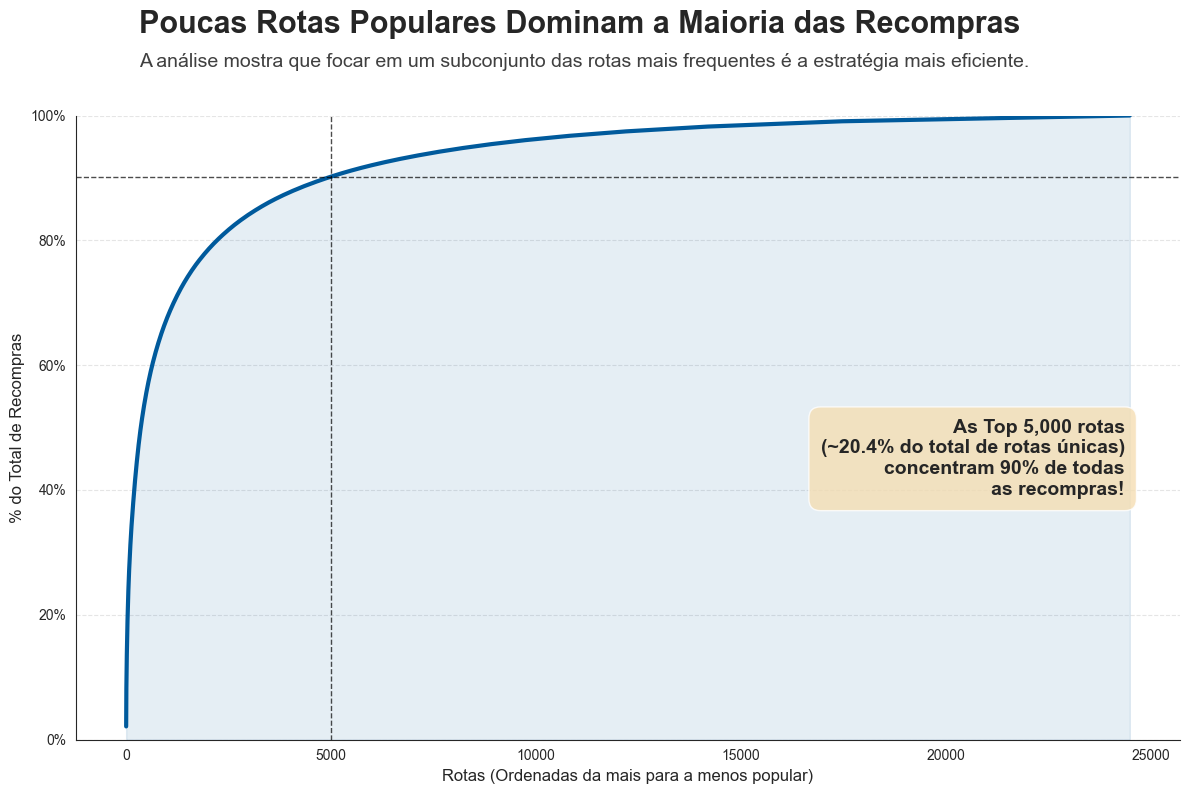

In [9]:
# 1. Contar a frequência de cada rota de destino ('proxima_rota')
route_counts = df_recomendacao['proxima_rota'].value_counts()
total_rotas_unicas = len(route_counts)

# 2. Calcular a distribuição cumulativa
cumulative_percentage = route_counts.cumsum() / route_counts.sum() * 100

# 3. Preparar dados para o gráfico
df_plot_pareto = pd.DataFrame({
    'rank': range(1, len(cumulative_percentage) + 1),
    'cumulative_percentage': cumulative_percentage.values
})

# 4. Configurar o Estilo do Gráfico
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'
fig, ax = plt.subplots(figsize=(12, 8))

# 5. Plotar a Curva e a Área
ax.plot(df_plot_pareto['rank'], df_plot_pareto['cumulative_percentage'], linewidth=3, color='#005A9C')
ax.fill_between(df_plot_pareto['rank'], df_plot_pareto['cumulative_percentage'], alpha=0.1, color='#005A9C')


# 6. Adicionar Títulos e Anotações
fig.text(0.12, 0.95, "Poucas Rotas Populares Dominam a Maioria das Recompras", 
         fontsize=22, fontweight='bold', ha='left', va='bottom')
fig.text(0.12, 0.91, "A análise mostra que focar em um subconjunto das rotas mais frequentes é a estratégia mais eficiente.", 
         fontsize=14, ha='left', va='bottom', color='#404040')


# 7. Focar a Atenção no Ponto Chave (Dinâmico com base em QTD_ROTAS)
try:
    # Use esta variável para controlar o ponto de destaque
    QTD_ROTAS = 5000
    
    # Cálculos dinâmicos
    percent_rotas = (QTD_ROTAS / total_rotas_unicas) * 100
    percent_coberto = df_plot_pareto.iloc[QTD_ROTAS - 1]['cumulative_percentage']
    
    # Adiciona linhas de referência
    ax.axvline(x=QTD_ROTAS, color='black', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(y=percent_coberto, color='black', linestyle='--', linewidth=1, alpha=0.7)
    
    # Caixa de texto com a informação chave dinâmica
    ax.text(
        0.95, 0.45,
        f'As Top {QTD_ROTAS:,} rotas\n'
        f'(~{percent_rotas:.1f}% do total de rotas únicas)\n'
        f'concentram {percent_coberto:.0f}% de todas\n'
        f'as recompras!',
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        ha='right',
        va='center',
        bbox=dict(boxstyle='round,pad=0.6', fc='wheat', alpha=0.8)
    )
except IndexError:
    print(f"Não há {QTD_ROTAS} rotas únicas para destacar. O valor máximo é {total_rotas_unicas}.")

# 8. Limpar o Gráfico
ax.set_xlabel('Rotas (Ordenadas da mais para a menos popular)', fontsize=12)
ax.set_ylabel('% do Total de Recompras', fontsize=12)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

# Ajusta o layout
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()